<a href="https://colab.research.google.com/github/alexf05/pclp3/blob/main/TEMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pclp3 tema
# FECHET Alex-Ciprian, 314CA
# JILAVEANU Mihnea, 314CA

Partea I - Fechet Alex
Am ales o problema de regresie liniara :predicția duratei de somn în funcție de obiceiuri zilnice.
Am optat pentru generarea sintetică a unui dataset care să aibă sens contextual.
Setul de date este compus din 8 coloane: varsta, gen, ore petrecute in fata unui ecran, numarul de cafele consumate, timpul de sport facut (masurat in minute), nivelul de stres, ora de culcare si coloana finala - durata de somn, pe care vom aplica si regresia liniara. Acesta este calculata cu o formula intuitiva, de la 8 ore, scadem proportional cu nr de ore de ecran, nr de cafele, intarzierea orei de culcare, zgomotului, si creste cu practicarea sportului.

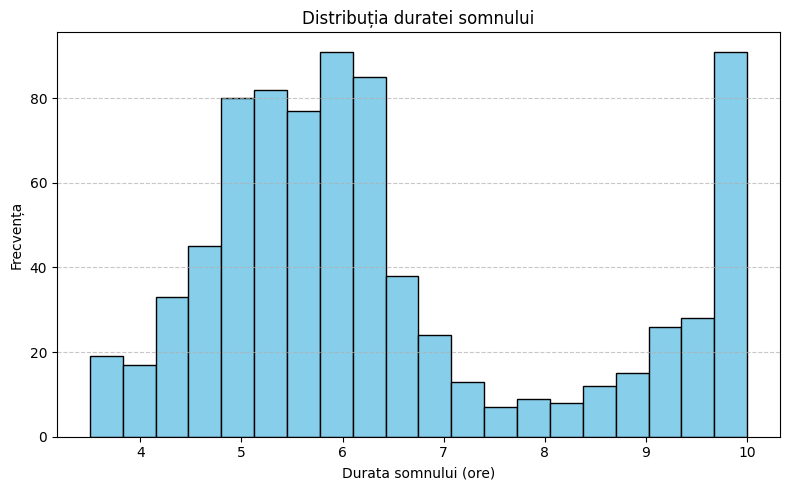

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Setare seed pentru consistență
np.random.seed(42)

# Număr total de exemple
num_rows = 800

# Variabile simulate
varsta = np.random.randint(18, 60, size=num_rows)
gen = np.random.choice(['M', 'F'], size=num_rows)
ore_ecran = np.round(np.random.normal(5, 2, size=num_rows), 1)
ore_ecran = np.clip(ore_ecran, 0, 12)

cafea = np.random.poisson(1.5, size=num_rows)
minute_sport = np.random.normal(30, 10, size=num_rows)
nivel_stres = np.random.choice(['scazut', 'mediu', 'ridicat'], size=num_rows, p=[0.3, 0.5, 0.2])

ora_culcare = np.random.normal(23, 1.5, size=num_rows)  # ex: între 20–26 natural
ora_culcare = np.clip(ora_culcare, 20, 28)              # limităm între 20 și 26
ora_culcare = np.where(ora_culcare >= 24, ora_culcare - 24, ora_culcare)
ora_culcare = np.around(ora_culcare, 1)
zgomot = np.random.random(size=num_rows) * 20 + 60 #intre 60-80

# Simulare logică a duratei somnului (variabila țintă)
durata_somn = (
    8
    - 0.3 * ore_ecran
    - 0.4 * cafea
    # + 0.008 * minute_sport * (minute_sport < 60)
    # + 0.25 * (minute_sport > 60)
    - 0.2 * (((20 <= ora_culcare) & (ora_culcare <= 24)) * ora_culcare - 22)
    - 0.5 * ora_culcare * ((4 >= ora_culcare) & (ora_culcare >= 0))
    - 0.5 * (zgomot > 70)
)
durata_somn = np.round(np.clip(durata_somn, 3.5, 10), 1)

# Creăm DataFrame
df = pd.DataFrame({
    'varsta': varsta,
    'gen': gen,
    'ore_ecran': ore_ecran,
    'cafea': cafea,
    'minute_sport': minute_sport,
    'nivel_stres': nivel_stres,
    'ora_culcare': ora_culcare,
    'zgomot' : zgomot,
    'durata_somn': durata_somn
})

plt.figure(figsize=(8, 5))
plt.hist(df["durata_somn"].dropna(), bins=20, edgecolor='black', color='skyblue')
plt.title("Distribuția duratei somnului")
plt.xlabel("Durata somnului (ore)")
plt.ylabel("Frecvența")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#stimulam lipsuri
total_cells = df.shape[0] * df.shape[1]
num_missing = int(total_cells * 0.05)

for i in range(num_missing):
    row = np.random.randint(0, df.shape[0])  # rând random
    col = np.random.randint(0, 9)

    df.iat[row, col] = np.nan



df.to_csv("full_dataset.csv", index=False)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.to_csv("train_dataset.csv", index=False)
df_test.to_csv("test_dataset.csv", index=False)
X = df.iloc[:, 0:8]
y = df.iloc[:, 8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [92]:
print("Valori lipsă în X_train:\n", X_train.isnull().sum())
print("\nValori lipsă în X_test:\n", X_test.isnull().sum())

# Calculăm media pentru fiecare coloană numerică din X_train
mean_values = X_train.mean(numeric_only=True)

# Înlocuim valorile lipsă în X_train și X_test cu media din X_train
X_train_filled = X_train.fillna(mean_values)
X_test_filled = X_test.fillna(mean_values)


Valori lipsă în X_train:
 varsta          31
gen             33
ore_ecran       35
cafea           26
minute_sport    23
nivel_stres     33
ora_culcare     35
zgomot          31
dtype: int64

Valori lipsă în X_test:
 varsta           8
gen              9
ore_ecran       10
cafea            6
minute_sport     8
nivel_stres      9
ora_culcare     12
zgomot           6
dtype: int64


In [93]:
# Pentru variabile numerice:
print("Statistici numerice X_train:")
print(X_train.describe())

print("\nStatistici numerice X_test:")
print(X_test.describe())

print("\nStatistici categorice X_train:")
print(X_train.describe(include='object'))

print("\nStatistici categorice X_test:")
print(X_test.describe(include='object'))


Statistici numerice X_train:
           varsta   ore_ecran       cafea  minute_sport  ora_culcare  \
count  609.000000  605.000000  614.000000    617.000000   605.000000   
mean    39.367816    5.173388    1.490228     29.824335    17.219504   
std     12.146015    2.004755    1.247144     10.073721     9.221757   
min     18.000000    0.000000    0.000000      0.705513     0.000000   
25%     29.000000    3.800000    1.000000     22.715384    20.000000   
50%     40.000000    5.200000    1.000000     30.071785    22.000000   
75%     50.000000    6.500000    2.000000     35.827376    23.000000   
max     59.000000   10.200000    7.000000     62.430930    24.000000   

           zgomot  
count  609.000000  
mean    69.820388  
std      5.653375  
min     60.004820  
25%     65.009659  
50%     69.864950  
75%     74.326507  
max     79.978094  

Statistici numerice X_test:
           varsta   ore_ecran       cafea  minute_sport  ora_culcare  \
count  152.000000  150.000000  154.000000

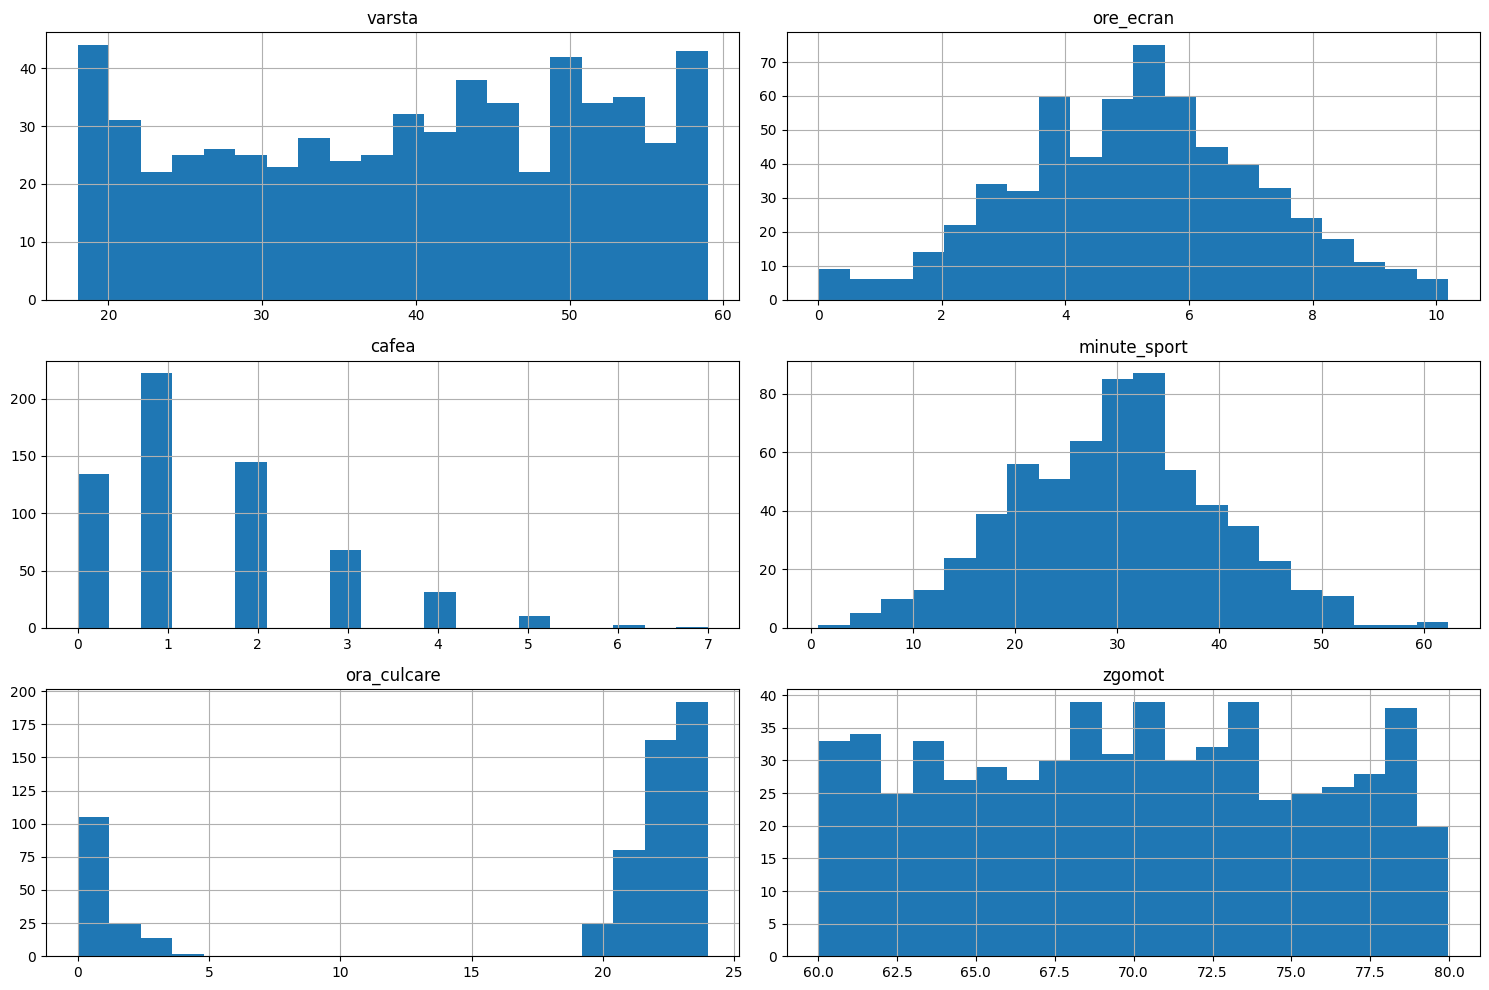

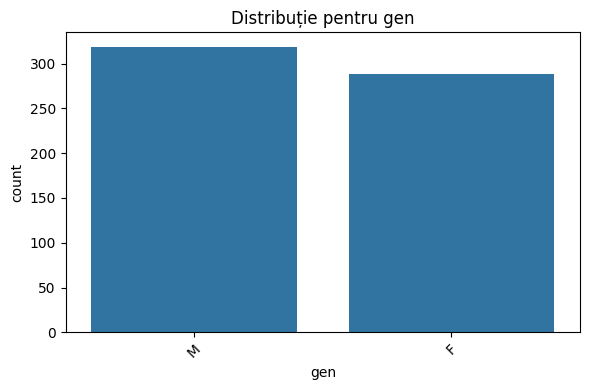

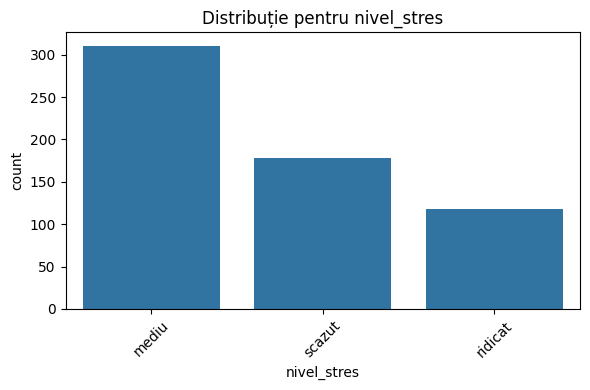

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograme pentru numerice
X_train.select_dtypes(include=['int64', 'float64']).hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Countplot pentru categorice (exemplu)
for col in X_train.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=X_train, x=col)
    plt.title(f"Distribuție pentru {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

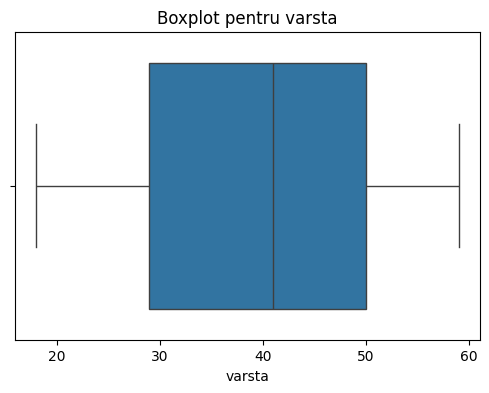

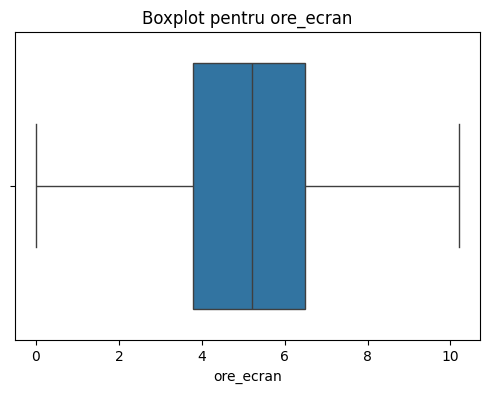

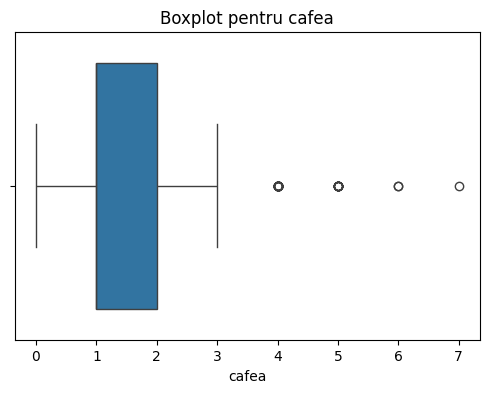

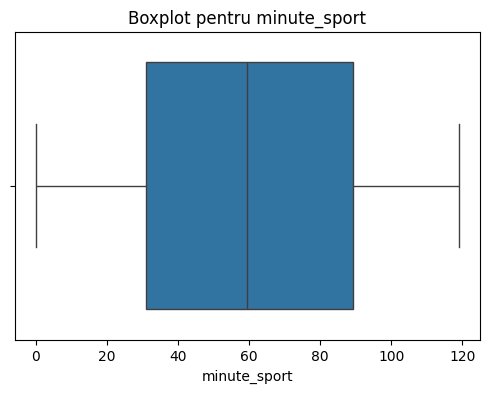

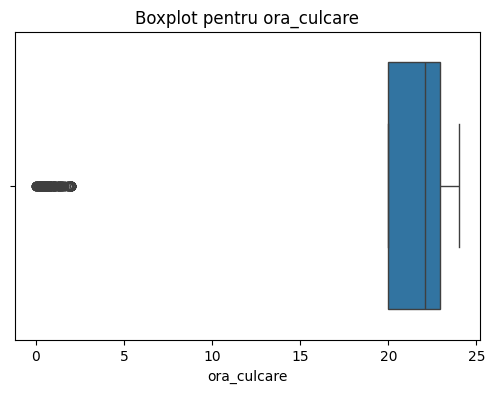

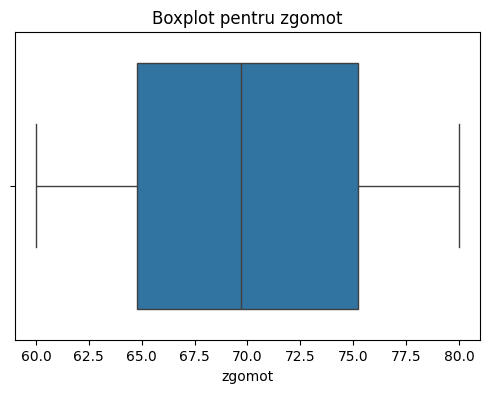

In [79]:
# Boxplot pentru fiecare coloană numerică
for col in X_train.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=X_train[col])
    plt.title(f"Boxplot pentru {col}")
    plt.show()

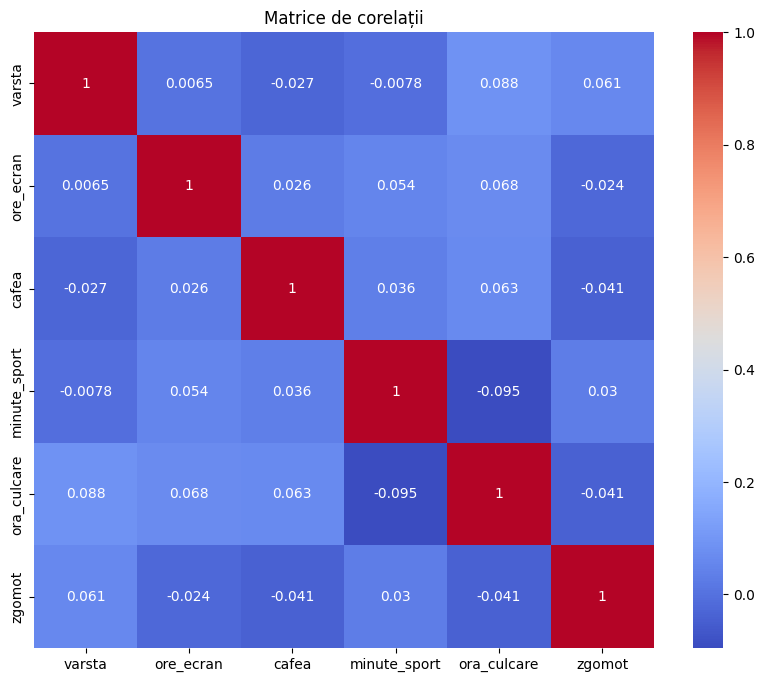

In [67]:
corr = X_train.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matrice de corelații")
plt.show()


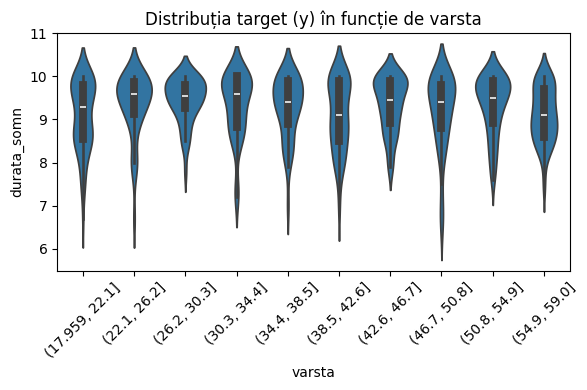

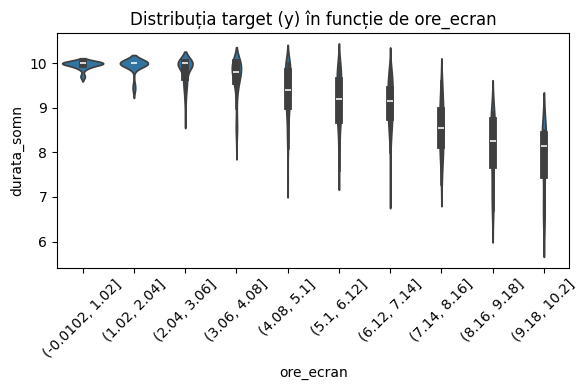

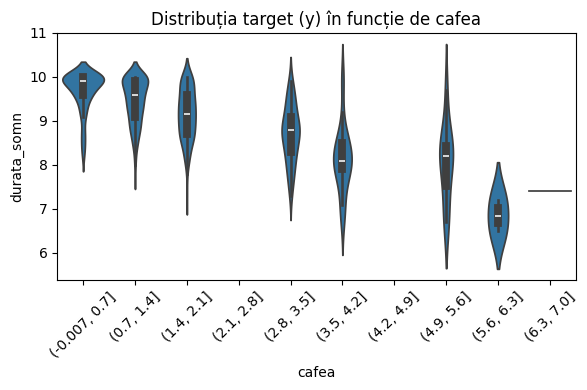

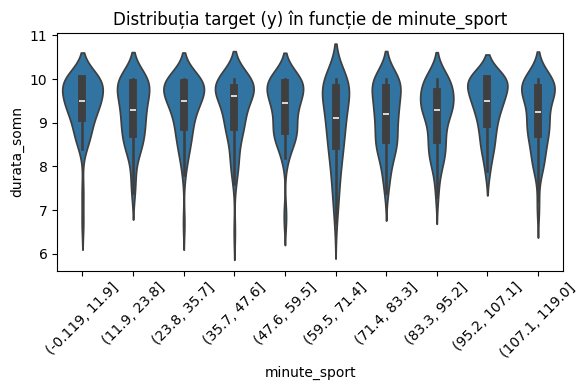

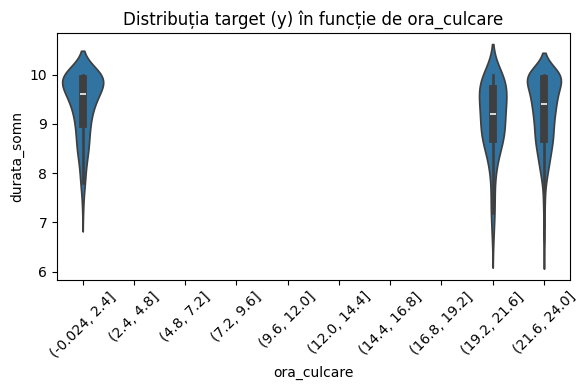

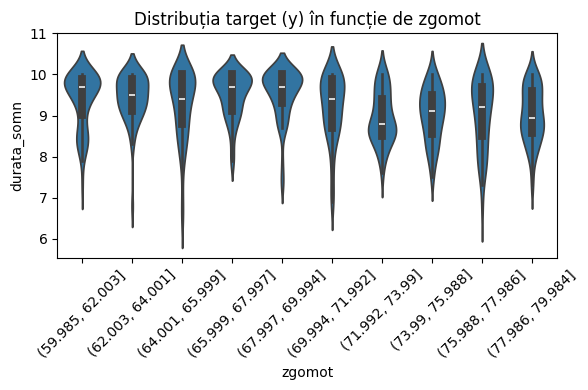

In [83]:
for col in X_train.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6, 4))
    # Grupăm valorile în 10 categorii (bins)
    binned = pd.cut(X_train[col], bins=10)
    sns.violinplot(x=binned, y=y_train)
    plt.xticks(rotation=45)
    plt.title(f"Distribuția target (y) în funcție de {col}")
    plt.tight_layout()
    plt.show()


In [69]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_filled.select_dtypes(include=[np.number]), y_train)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicții pe test
y_pred = model.predict(X_test_filled.select_dtypes(include=[np.number]))

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 0.49
MAE: 0.32
R²: 0.93


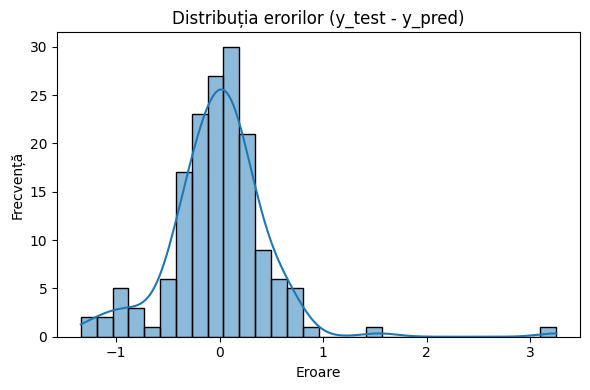

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

errors = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(errors, kde=True, bins=30)
plt.title("Distribuția erorilor (y_test - y_pred)")
plt.xlabel("Eroare")
plt.ylabel("Frecvență")
plt.tight_layout()
plt.show()


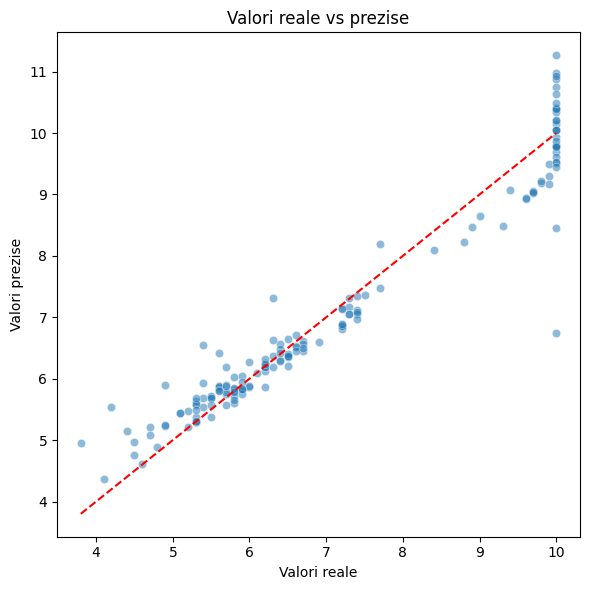

In [71]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valori reale")
plt.ylabel("Valori prezise")
plt.title("Valori reale vs prezise")
plt.tight_layout()
plt.show()
